# Projekt zaliczeniowy - Przetwarzanie obrazów cyfrowych
Autor: **Patryk Ciepiela**

In [6]:
# Ładowanie bibliotek

import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, exposure, morphology, io, img_as_ubyte
from skimage.color import rgb2gray
import cv2
import warnings
import time

In [7]:
COLOR_FOREGROUND = 255
COLOR_BACKGROUND = 0
COLOR_FOREGROUND_INV = 0
COLOR_BACKGROUND_INV = 255

DEBUG = True
if not DEBUG:
    warnings.filterwarnings('ignore')

In [8]:
# Metody pomocnicze
def is_in_image(shape, px=0, py=0):
    return ((px>=0) and (px < shape[0]) and (py >= 0) and (py < shape[1]))

def bfs(i,j,image,color):
    q = [(i,j)]
    while q:
        ii,jj = q.pop(0)
        for dx in range(-1,2):
            for dy in range(-1,2):
                if dx == 0 and dy == 0:
                    continue
                a = ii + dx
                b = jj + dy
                if is_in_image(image.shape, a, b) and image[a][b] == COLOR_FOREGROUND_INV:
                    image[a][b] = color
                    q.append((a,b))

def segment(image):
    segment_table = image.copy()
    cnt = 1
    x = 0
    for i in range(segment_table.shape[0]):
        for j in range(segment_table.shape[1]):
            v = segment_table[i][j]
            if v == COLOR_FOREGROUND_INV:
                x += 1
                segment_table[i][j] = cnt
                bfs(i,j,segment_table,cnt)
                cnt += 1
                
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            v = segment_table[i][j]
            if v == COLOR_BACKGROUND_INV:
                segment_table[i][j] = 0
                
    return x,segment_table

# metoda wyświetlająca obraz w notatniku
def showimg(img, title="Obraz", verbose=False, cmap="gray"):
    if verbose:
        print(img.shape, img.dtype)
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

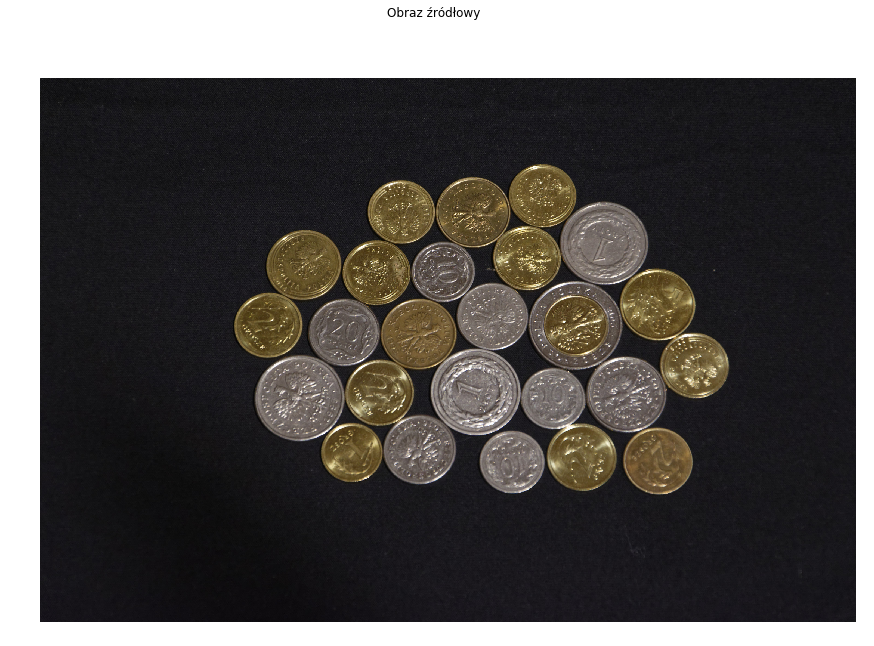

C:\Users\Machina\Anaconda3\envs\py36\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


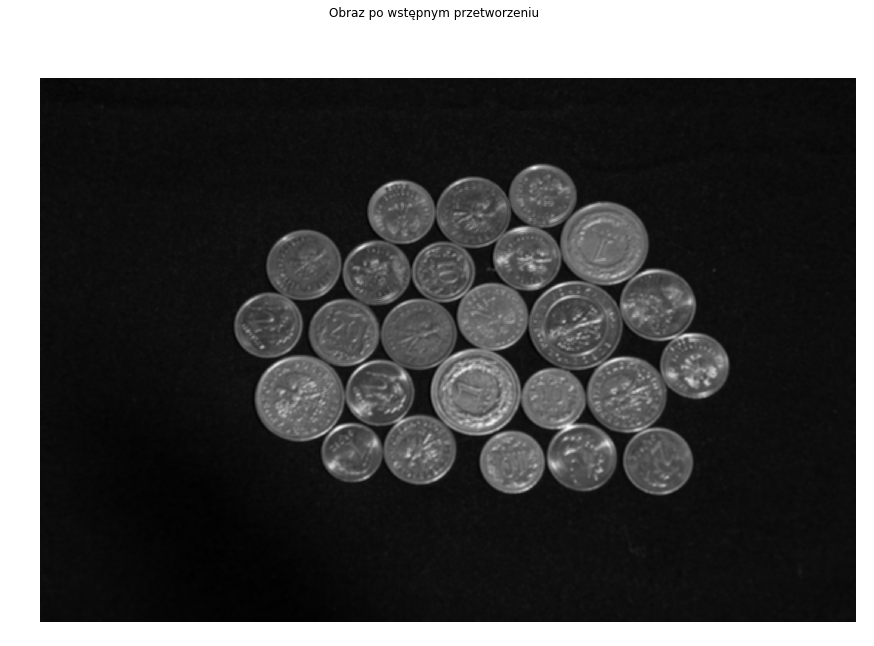

In [21]:
sourceimg = io.imread("source.jpg")

showimg(sourceimg, title="Obraz źródłowy")

processedimg = sourceimg.copy()
processedimg = img_as_ubyte(rgb2gray(processedimg))
processedimg = cv2.blur(processedimg, (11,11))

bwblurredimg = processedimg.copy()

showimg(bwblurredimg, title="Obraz po wstępnym przetworzeniu")

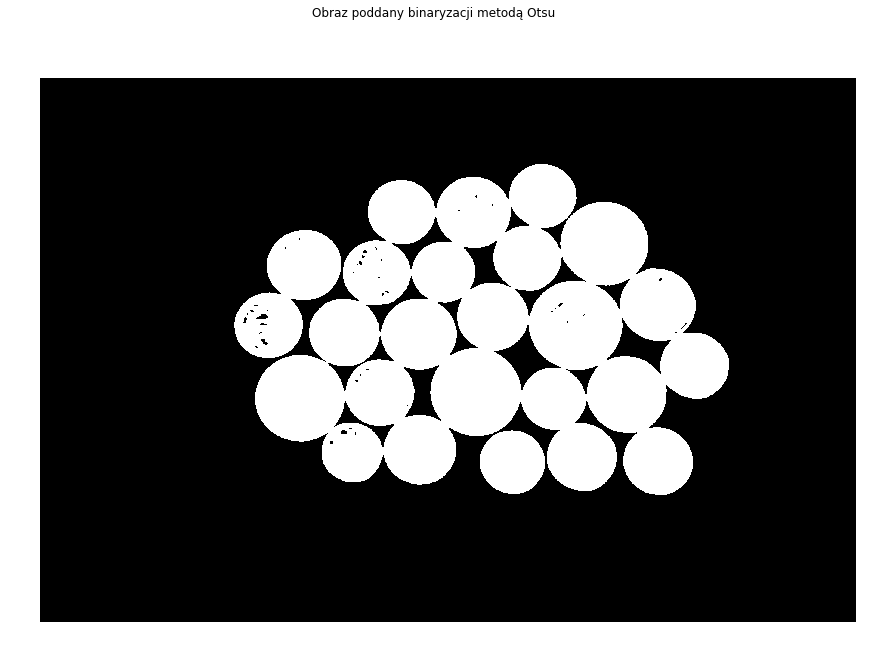

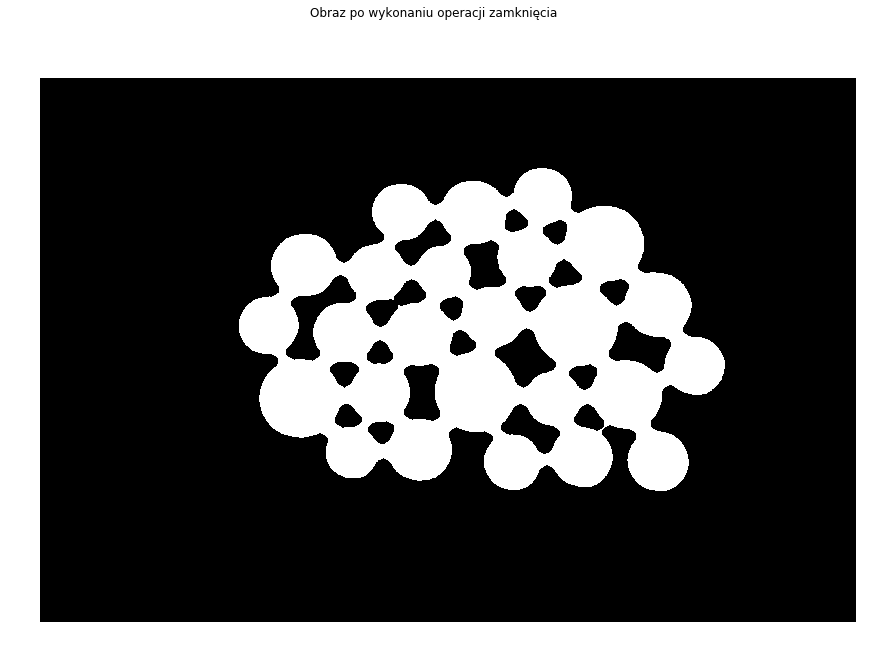

In [25]:
th = 128
th, bim = cv2.threshold(bwblurredimg, thresh=th, maxval=255, type=cv2.THRESH_OTSU)
processedimg = bim
showimg(processedimg, title="Obraz poddany binaryzacji metodą Otsu")

morphKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
processedimg = cv2.bitwise_not(processedimg)
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_OPEN, kernel=morphKernel, iterations=4)
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_DILATE, kernel=morphKernel, iterations=5)
processedimg = cv2.bitwise_not(processedimg)

binaryimg = processedimg.copy()

showimg(processedimg, title="Obraz po wykonaniu operacji zamknięcia")


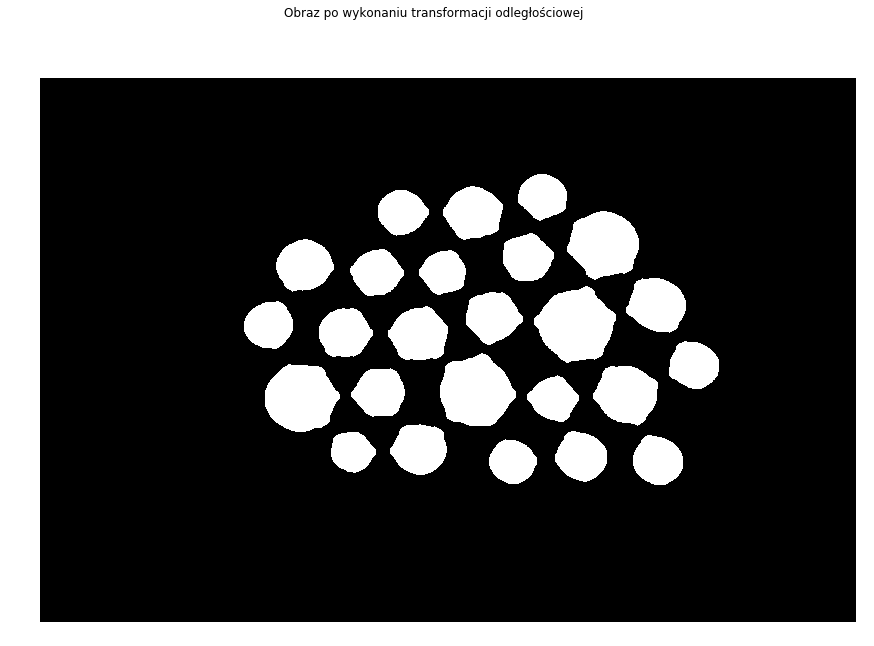

In [60]:
distimg = cv2.distanceTransform(binaryimg, cv2.DIST_L2, 5)
distimg = np.uint8(distimg)
_, distimg = cv2.threshold(distimg, thresh=50, maxval=255, type=cv2.THRESH_BINARY)
distimg = cv2.morphologyEx(distimg, op=cv2.MORPH_DILATE, kernel=morphKernel, iterations=10)
showimg(distimg, title="Obraz po wykonaniu transformacji odległościowej")

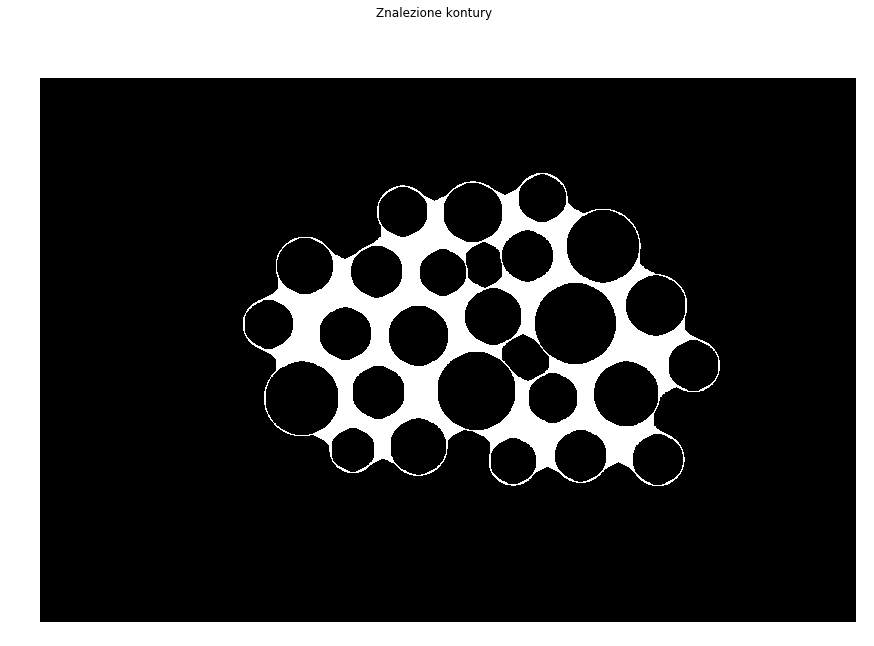

In [77]:
_, contours, hierarchy = cv2.findContours(distimg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contoursimg = np.zeros_like(binaryimg)
for i in range(len(contours)):
    mycircle = contours[i]
    (x,y),radius = cv2.minEnclosingCircle(mycircle)
    center = (int(x),int(y))
    radius = int(radius)
    cv2.circle(contoursimg,center,radius,255,3)
contoursimg = cv2.morphologyEx(contoursimg, op=cv2.MORPH_CLOSE, kernel=morphKernel, iterations=20)
showimg(contoursimg, title="Znalezione kontury")

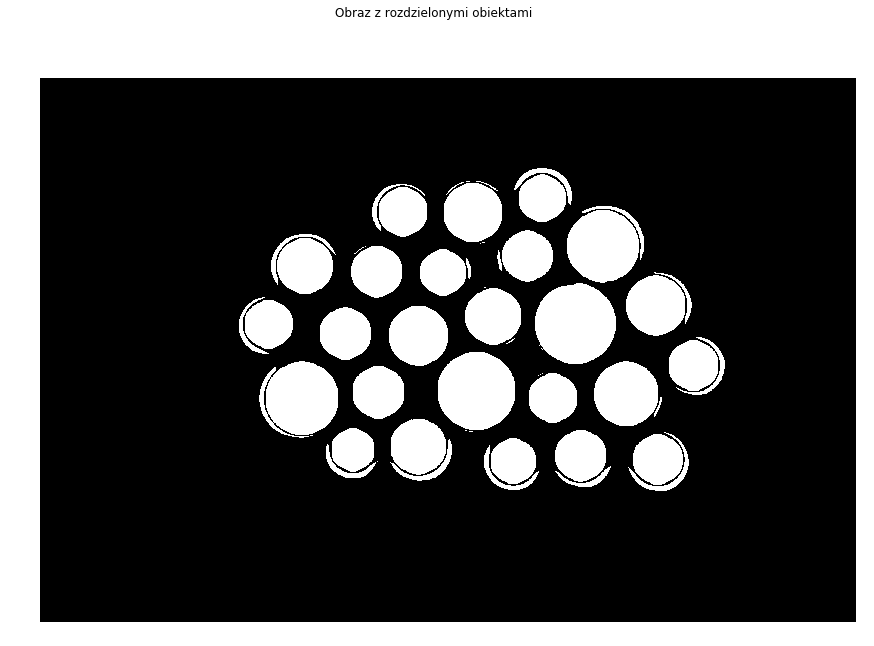

In [78]:
separated_img = cv2.bitwise_and(processedimg, cv2.bitwise_not(contoursimg))
showimg(separated_img, title="Obraz z rozdzielonymi obiektami")

In [83]:
time_now = time.time()
obj_count, segment_table = segment(cv2.bitwise_not(separated_img))
time_delta = time.time() - time_now
print("Segmentacja ukończona w %.3f sekund" % time_delta)

Segmentacja ukończona w 26.703 sekund


Liczba obiektów: 26
{0: 5138171, 2: 23701, 4: 37190, 6: 25551, 8: 55364, 9: 27243, 11: 33023, 13: 27909, 16: 22553, 20: 37825, 21: 69378, 23: 33607, 25: 24865, 26: 37805, 27: 28523, 30: 26673, 32: 65092, 33: 57205, 34: 44401, 35: 29151, 38: 25551, 41: 32925, 42: 19737, 44: 27909, 46: 26673, 47: 21975}


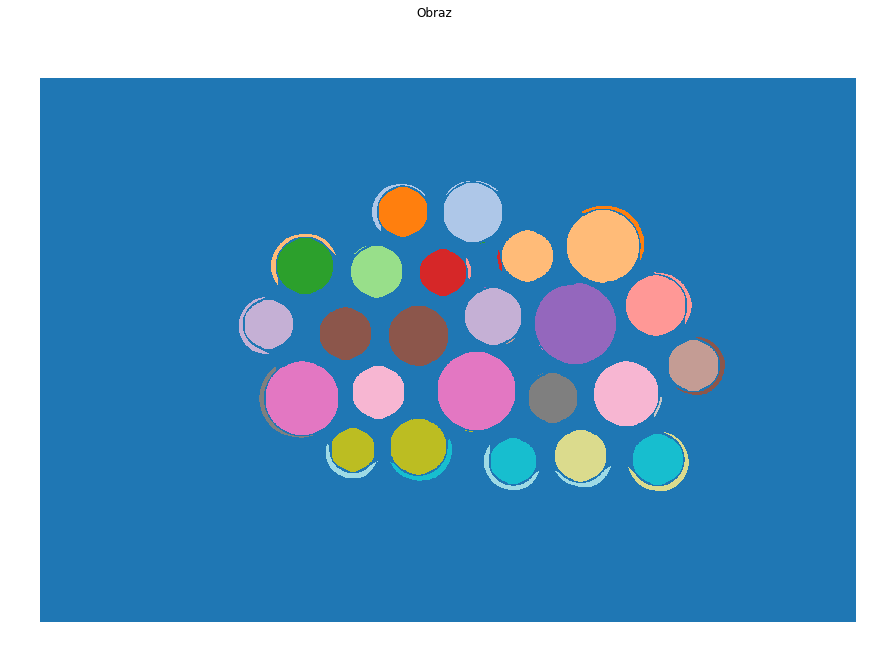

In [84]:
denoised_segment = morphology.remove_small_objects(segment_table, min_size=7500)
unique_elements, counts_elements = np.unique(denoised_segment, return_counts=True)
obj_data = dict(zip(unique_elements, counts_elements))
print("Liczba obiektów: %d" % len(obj_data))
print(obj_data)
showimg(segment_table, cmap="tab20")